In [101]:
import os
import csv
import numpy as np

class Result:
    
    def __init__(self, name, age):
        self.name = name
        self.counts = dict()
        self.snp_sums = dict()
        self.age = age
        self.read_length = 0
        self.snps = dict()
        self.coverage = 1
        
    def set_count(self, kmer_name, count):
        self.counts[kmer_name] = count
        
    def normalized_tel(self):
        sum_all = (sum(self.counts.values())-self.counts['TTAGGGTTAGGGTTAGGGTTAGGGT'])/3000
        return (self.tel_count()/sum_all)
    
    def tel_count(self):
        return self.counts['TTAGGGTTAGGGTTAGGGTTAGGGT']
        
    def get_label(self):
        return "{}:{}, {}".format(self.name[7:], 
                              int(self.counts['GAGTCAAAAGCAGATACGTGTGTCA']), int(self.counts['GAGTCAAAAGCAGATACATGTGTCA']))
        
    def __str__(self):
        return 'Result {}, age: {}, {} | {}'.format(self.name, self.age, self.tel_count(), self.normalized_tel())
    
    def __repr__(self):
        return 'Result {}, age: {}, {} | {}'.format(self.name, self.age, self.tel_count(), self.normalized_tel())
    
    def get_snp_vals(self):
        result = list()
        for k,s in self.snps.iteritems():
            if s['main']:
                result.append(s['main'])
            else:
                result.append(s['minor'])
        return result
        
    
    def get_input(self):
        output = list()
        output.append(self.normalized_tel())
        #output.append(self.age)
        #output.append(self.age)
        rss = ['rs621559',
            'rs11125529',
            'rs4452212',
            'rs16859140',
            'rs12696304',
            'rs10936599',
            'rs1317082',
            'rs10936601',
            'rs7680468',
            'rs2736100',
            'rs2098713',
            'rs2736428',
            'rs654128',
            'rs34596385',
            'rs11787341',
            'rs10904887',
            'rs10466239',
            'rs9419958',
            'rs9420907',
            'rs4387287',
            'rs17653722',
            'rs398652',
            'rs4902100',
            'rs74019828',
            'rs3027234',
            'rs2162440',
            'rs412658',
            'rs1975174',
            'rs6028466',
            'rs73394838']
        for r in rss:
            if r in self.snps:
                output.append(1 if bool(self.snps[r]['minor']) else -1)
        
        #output = output+snps
        return output

                
    
    def calculate_snps(self):
        with open ('./static/snp_kmers.txt') as f:
            reader = csv.reader(f, delimiter='\t')
            for row in reader:
                name = row[0]
                alt = False
                if name[0:4] == 'ALT_':
                    name = name[4:].split(':')[0]
                    alt = True
                else:
                    name = name.split(':')[0]
                
                if name not in self.snps:
                    self.snps[name] = dict()
                    self.snps[name]['main'] = 0
                    self.snps[name]['minor'] = 0
                    
                count = int(self.counts[row[1].strip()])
                    
                if alt:
                    self.snps[name]['minor'] += count
                else:
                    self.snps[name]['main'] += count
            f.close()
                    

                    
print "Starting..."
        
ages = dict()
read_lengths = dict()
with open('./static/SraRunTable.txt') as run_table:
    r = csv.reader(run_table, delimiter='\t')
    r.next()
    for row in r:
        ages[row[8]] = row[11]
        read_lengths[row[8]] = row[0]
        
def get_age(name):
    return int(ages[name])

def get_read_length(name):
    return int(read_lengths[name])

def status():
    tot_m, used_m, free_m = map(str, os.popen('free -t -h').readlines()[-1].split()[1:])
    print used_m
    
ref_counts = dict()
with open('./static/ref37_counts.txt') as f:
    reader = csv.reader(f, delimiter='\t')
    for row in reader:
        name = row[0]
        normal_count = int(row[1])
        ref_counts[name] = normal_count
    f.close()

print "Runtable OK!"
    
results = list()
k=1
for file in os.listdir('./files'):
    name = file[:-4]
    try:
        age = get_age(name)
    except:
        continue
    result = Result(name, age)
    result.read_length = get_read_length(name)
    with open('./files/'+file) as f:
        reader = csv.reader(f, delimiter='\t')  
        for row in reader:
            result.set_count(row[0], float(row[1]))
    result.calculate_snps()
    results.append(result)
    f.close()
    k += 1
    if k%2000==0:
        status()
        break

print "OK!"



Starting...
Runtable OK!
2.6G
OK!


3439.66405375
1.70117143351


<IPython.core.display.Javascript object>


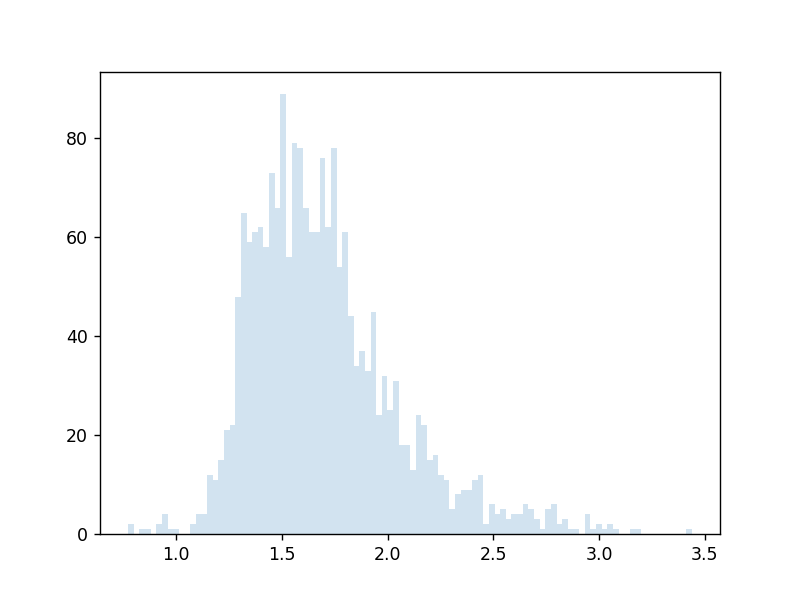

In [110]:
%matplotlib nbagg

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

# kmers_per_read = rl - k + 1

i1 = 153581.0/44.65
print i1
k = 0
for r in results:
    a = r.counts['CTGGGCGACAGAGCGAGACTCCGTC']
    #print a/i1
    #print "---------"
    k+=1
    if k > 10:
        break
print np.mean(map(lambda r: r.counts['CTGGGCGACAGAGCGAGACTCCGTC']/i1, results))
plt.hist(map(lambda r: r.counts['CTGGGCGACAGAGCGAGACTCCGTC']/i1, results), 100, alpha=0.2)
plt.show()


CTGTAATCCCAGCACTTTGGGAGGC
1.64484511276


<IPython.core.display.Javascript object>


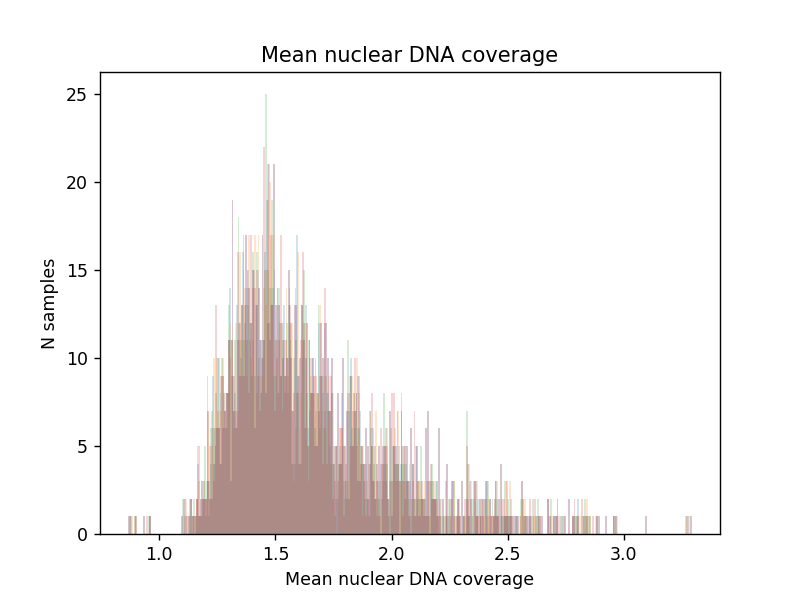

CCTGTAATCCCAGCACTTTGGGAGG
1.64756061335
GCCTGTAATCCCAGCACTTTGGGAG
1.64000160645
TGTAATCCCAGCACTTTGGGAGGCC
1.63851834469


In [32]:
%matplotlib nbagg



import operator
sorted_refs = sorted(ref_counts.items(), key=operator.itemgetter(1))
sorted_refs = list(reversed(sorted_refs))
top_refs = [a[0] for a in sorted_refs[0:4]]
#plt.grid()


for a in top_refs:
    y = list(map(lambda r: r.counts[a]/ref_counts[a]*2.5, results))
    print a
    print np.average(y)
    plt.hist(y, 300, alpha=0.2)



#plt.hist(c, 500, normed=1, alpha=0.5, facecolor="red")
#plt.axis([1, 2.8, 0, 320])
plt.xlabel('Mean nuclear DNA coverage')
plt.ylabel('N samples')
plt.title("Mean nuclear DNA coverage")
plt.show()

999
2902.48642205


<IPython.core.display.Javascript object>


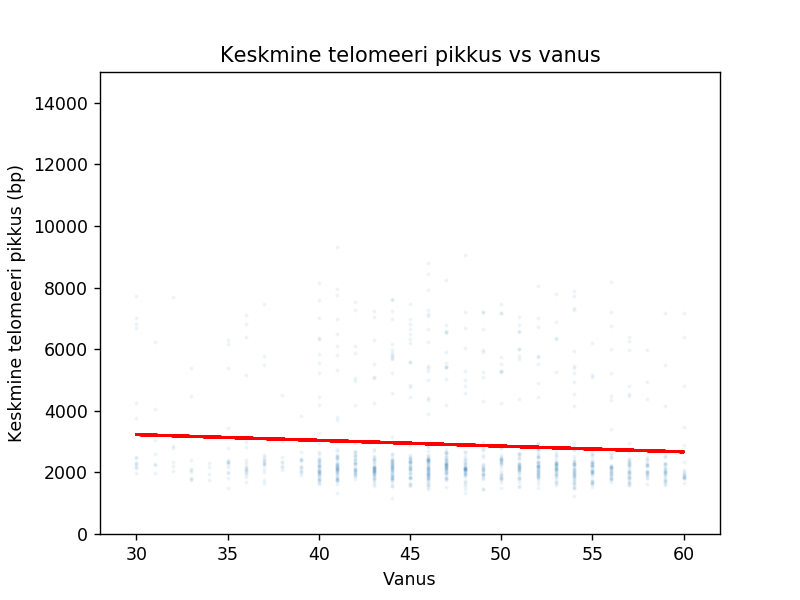

y=-18.661011x+(3786.726946)
2902.48642205
119417.183183


In [69]:
%matplotlib nbagg

def get_coverage(r):
    top_refs = [a[0] for a in sorted_refs[0:4]]
    avg = np.average([r.counts[a]/ref_counts[a]*2.5 for a in top_refs if a is not "TTAGGGTTAGGGTTAGGGTTAGGGT"])
    return avg

def calculate_avg_len(r):
    count = r.tel_count()
    coverage = get_coverage(r)
    return (count*25)/(coverage*92)

def get_x(r):
    return r.age

f_results = [r for r in results if calculate_avg_len(r) > 3800]
f_results = results

x = list(map(get_x, f_results))
y = list(map(calculate_avg_len, f_results))

print len(x)
print np.average(y)
labels = list(map(lambda r: r.get_label(), f_results))
plt.scatter(x, y, s=2, alpha=0.05)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")
plt.axis([28, 62, 0, 15000])
plt.xlabel('Vanus')
plt.ylabel('Keskmine telomeeri pikkus (bp)')
plt.title("Keskmine telomeeri pikkus vs vanus")

plt.show()

print "y=%.6fx+(%.6f)"%(z[0],z[1])
print np.average(y)
print np.average([r.counts['TGTAATCCCAGCACTTTGGGAGGCC'] for r in f_results])

In [89]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, Embedding, Input, Conv2D,MaxPooling1D, LSTM,SimpleRNN,Reshape
from keras.layers.convolutional import Conv1D
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical,normalize
import random

d = 31

dummy_w = np.random.rand(d,2)
#print dummy_w

def get_dummy_input(r):
    output = list()
    
    a_input = 0
    for c in range(0,d):
        choice = 1 if bool(random.getrandbits(1)) else 0
        a_input += r.age*dummy_w[c][choice]
        output.append(1 if choice else -1)
        
        
    output.append(a_input)
    
    return output

def get_counts(r):
    res = list()
    res.append(r.counts['TTAGGGTTAGGGTTAGGGTTAGGGT'])
    res.append(r.counts['CCTGTAATCCCAGCACTTTGGGAGG'])
    res.append(r.counts['TGAGAAAGCTGTCTCTCTGCCCCAG'])
    res.append(r.counts['CTGAGAAAGCTGTTTCTCTGCCCCA'])
    res.append(r.counts['CGAAAAATCGGTTTACTGTAAGGTA'])
    res.append(r.counts['AAAATCGGTCTACTGTAAGGTATGG'])
    res.append(r.counts['GCAGTATTCGCACCACTGTGAGCAC'])
    res.append(r.counts['TCGCACCATTGTGAGCACCTTTTAG'])
    res.append(r.counts['ATCAAGTAAGTCTGAGAAGTACTAA'])
    res.append(r.counts['ACTAAAACATCATCTTGGCCCTTGA'])
    res.append(r.counts['GACTAAAACATAATCTTGGCCCTTG'])
    res.append(r.counts['TTCTTTCTCTAAGCAATCCGGAGTC'])
    
    return res
    
    

#inputs = list(map(lambda r: get_dummy_input(r), results))
inputs = list(map(get_counts, f_results))
outputs = list(map(lambda r: r.age, f_results))

inputs = np.array(inputs)
outputs = np.array(outputs)

print inputs[0]
print outputs[0]


model = Sequential()
a = inputs.shape[1]

print inputs[0].shape

model.add(Dense(inputs[0].shape[0],kernel_initializer="uniform", input_shape=inputs[0].shape, activation = "linear"))
model.add(Dense(150, activation='linear'))
model.add(Dense(150, activation='linear'))
model.add(Dense(150, activation='linear'))
model.add(Dense(1, activation='linear')) 


model.compile(loss='mse',
              optimizer='rmsprop')

history = model.fit(inputs, outputs, epochs=100,  batch_size=32, validation_split=0.1, verbose=0)
print "OK!"

[  3.21240000e+04   1.32323000e+05   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
45
(12,)
OK!


[152.75585969059543]
[111.51117720949068]
[[ 41.59739304]
 [ 50.16474152]
 [ 44.54394913]
 [ 46.68017197]
 [ 47.85059738]
 [ 44.83269501]
 [ 44.74482727]
 [ 47.9312439 ]
 [ 48.02203751]
 [ 42.88005829]
 [ 48.29429626]
 [ 51.11823273]
 [ 58.53788376]
 [ 47.2044754 ]
 [ 43.27282715]
 [ 45.63977051]
 [ 48.23281097]
 [ 49.87506485]
 [ 51.80753326]
 [ 40.87425613]
 [ 71.31362152]
 [ 47.30624771]
 [ 51.70293808]
 [ 48.29853821]
 [ 59.31756973]]
[48 52 47 55 30 40 43 39 44 47 49 40 35 41 51 52 45 37 42 40 48 31 46 52 56]
48-[ 41.59739304]=[ 6.40260696]
52-[ 50.16474152]=[ 1.83525848]
47-[ 44.54394913]=[ 2.45605087]
55-[ 46.68017197]=[ 8.31982803]
30-[ 47.85059738]=[-17.85059738]
40-[ 44.83269501]=[-4.83269501]
43-[ 44.74482727]=[-1.74482727]
39-[ 47.9312439]=[-8.9312439]
44-[ 48.02203751]=[-4.02203751]
47-[ 42.88005829]=[ 4.11994171]
49-[ 48.29429626]=[ 0.70570374]
40-[ 51.11823273]=[-11.11823273]
35-[ 58.53788376]=[-23.53788376]
41-[ 47.2044754]=[-6.2044754]
51-[ 43.27282715]=[ 7.72717285]
5

<IPython.core.display.Javascript object>


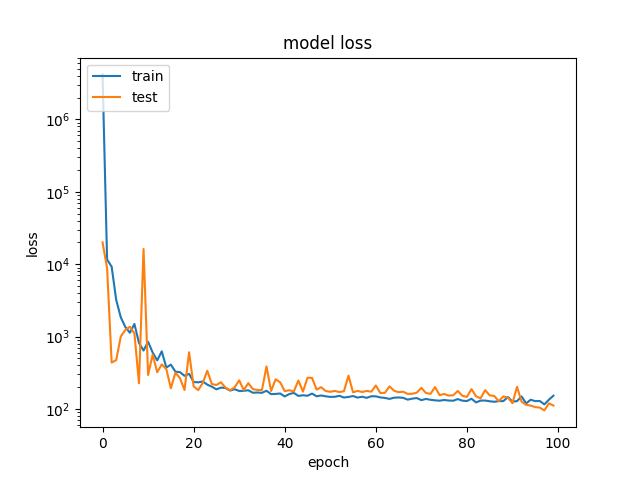

In [91]:
%matplotlib nbagg

print history.history['loss'][-1:]
print history.history['val_loss'][-1:]

#print inputs[-25:]

print model.predict(inputs[-25:])
print outputs[-25:]

t = outputs[-25:]
p = model.predict(inputs[-25:])

for i in range(25):
    print str(t[i])+"-"+str(p[i])+"="+str(t[i]-p[i])

plt.semilogy(history.history['loss'])
plt.semilogy(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()